### What is Classification
Classification is one of the most common supervised learning tasks (along with regression).
While regression predicts values (like house prices), classification predicts classes or categories.
Think of it loke sortinng items into different boxes - is this email spam or not?, is this picture a dog or a cat?

##### The MNIST Dataset
We're going to learn classification using a famous dataset called MNIST - it's like the "Hello World" of machine learning!

##### What is MNIST?
- 70k small images of handwritten digits (0-9)
- Written by high school students and US Census Bureau employees
- Each image is labeled with the digit it represents
- Each image is 28x28 pixels (784 features total)

Lets see how to get started:

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

### Visualizing a Digit
Each image is stored as a flat array of 784 pixel intensities (0 = white, 255 = black)

to see it:

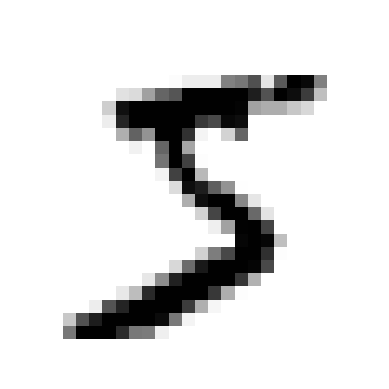

In [7]:
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

### Preparing the Data
Before getting started, split the data properly:

In [8]:
import numpy as np

y = y.astype(np.uint8)

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

### Training a Binary Clasifier
one that only answers yes/no questions

building a "5-detector" that tells us if an image is a 5 or not

##### Step 1: Create Binary Labels

In [9]:
y_train_5 = (y_train == 5) # true for 5s, false for others
y_test_5 = (y_test == 5)

##### Step 2: Train a Classifier
using a Stochastic Gradient Descent (SGD) - it's fast and works well with large datasets

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [11]:
sgd_clf.predict([some_digit]) # some_digit was assigned to 5 prev. cell

array([ True])

### Performance Measures: How good is Classifier?
##### 1. Accuracy (Can be misleading)
let's check accuracy using cross-validation

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

cv=3: Specifies 3-fold cross-validation, meaning the training data is split into 3 equal parts (folds). The model is trained on 2 folds and tested on the remaining fold, repeating this process 3 times so each fold is used as a test set once.

What Cross-Validation Does:
The dataset (X_train, y_train_5) is divided into 3 folds.
For each fold:
The model is trained on 2/3 of the data (two folds).
The model is tested on the remaining 1/3 (the third fold).
The accuracy score is computed for the test fold.
This process repeats 3 times, with a different fold used as the test set each time.
The result is an array of 3 accuracy scores, one for each fold.

over 93% accuracy...
what if we made a dumb classifier that always says "not 5"?

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

it gets 90% accuracy, cuz only 10% of images are 5s.
This shows why accuracy isn't always the best metric for imbalanced datasets.

##### Confusion Matrix (The Truth Revealer)
A confusion matrix shows us exactly what kinds of mistakes our classifier makes:

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

[True Negatives, False Postives],
[False Negatives, True Positives]

Reading the matrix:

- 53,892 non-5s correctly identified (True Negatives)
- 687 non-5s wrongly called 5s (False Positives)
- 1,891 actual 5s missed, called non-5 (False Negatives)
- 3,530 5s correctly identified (True Positives)

##### Precision and Recall (The Dynamic Duo)
Precision: When we say it's a 5, how often are we right?

Recall: Of all the actual 5s, how many did we catch?

Precision = True Positives / (True Positives + False Positives)
        = 3,530 / (3,530 + 687)

Recall = True Positives / (True Positives + False Negatives)
        = 3,530 / (3,530 + 1,891)

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

##### F1 Score (The Harmonic Balance)
The F1 score combines precision and recall into a single metric

F1 = 2 / (1 / Precision + 1/ Recall)
    = TP / (TP + (FN + FP) / 2)

In [17]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

##### Precision/Recall Trade-off
we can adjust our classifier's behavior by changing its decision threshold

- Higher Threshold = higher precision, lower recall
- Lower Threshold = higher recall, lower precision

In [18]:
y_scores = sgd_clf.decision_function([some_digit])

# Default threshold
threshold = 0
y_some_digit_pred = (y_scores > threshold) # True

# raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold) # False

(Extra topic)
##### How to decide threshold?

First, use the cross_val_predict()
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of prediction

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision
and recall for all possible thresholds

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [21]:
# Suppose we decided to aim for 90% precision
# threshold for 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [22]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [23]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [24]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

ROC curve is another common tool used with binary classifiers. It is very similar to the p/r curve, but instead of plotting precision vs. recall, the ROC curve plots the true positive rate(anothe name for recall) against the false psoitive rate

Since the ROC curve is so similar to the precision/recall (PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives. Otherwise, use the ROC curve. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the top-
left corner).

### Multiclass Classification
Whereas binary classifiers distinguish between two classes, multiclass classifiers (also
called multinomial classifiers) can distinguish between more than two classes.

One way to create a system that can classify the digit images into 10 classes (from 0 to
9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-
detector, and so on). Then when you want to classify an image, you get the decision
score from each classifier for that image and you select the class whose classifier out‐
puts the highest score. This is called the one-versus-the-rest (OvR) strategy (also called
one-versus-all

Another strategy is to train a binary classifier for every pair of digits: one to distin‐
guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels. The main advan‐
tage of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.

- from sklearn.multiclass import OneVsRestClassifier
- ovr_clf = OneVsRestClassifier(SVC())
- ovr_clf.fit(X_train, y_train)
- ovr_clf.predict([some_digit])
- = array([5], dtype=uint8)
- len(ovr_clf.estimators_)
- = 10

training an SGDCLassifier:

In [25]:
# Train on all classes
sgd_clf.fit(X_train, y_train)  # y_train has values 0-9
sgd_clf.predict([some_digit])   # array([5])

# Check the scores for each class
sgd_clf.decision_function([some_digit])
# Returns 10 scores, one per class

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [26]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

##### Improving Performance
~86% not bad, simply scaling the data can dramatically improve results

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: 

### Error Analysis

Here we assume that we have found a promising model and we wanna find ways to improve it
One way to do it is to analyze the types of errors it makes.

First look at the confusion matrix:

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The bright spots off the diagonal show common confusions. For example, many 8s are misclassified as other digits, and 3s and 5s are often confused with each other.

In [ ]:
# Let's focus on the ERRORS

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Analyzing the confusion matrix often gives you insights into ways to improve your
classifier. Looking at this plot, it seems that your efforts should be spent on reducing
the false 8s. For example, you could try to gather more training data for digits that
look like 8s (but are not) so that the classifier can learn to distinguish them from real
8s. Or you could engineer new features that would help the classifier—for example,
writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5
has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or
OpenCV) to make some patterns, such as closed loops, stand out more.

### Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance.

Consider a face-
recognition classifier: what should it do if it recognizes several people in the same
picture? It should attach one tag per person it recognizes. Say the classifier has been
trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is
shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes,
Bob no, Charlie yes”). Such a classification system that outputs multiple binary tags is
called a multilabel classification system.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create two labels: is_large (7,8,9) and is_odd
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])  # array([[False, True]])
# Correct! 5 is not large but is odd

digit 5 is indeed not large(False) and odd (True)

There are many ways to evaluate a multilabel classifier, and selecting the right metric
really depends on your project.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred,average="macro")

This assumes that all labels are equally important, however, which may not be the
case. In particular, if you have many more pictures of Alice than of Bob or Charlie,
you may want to give more weight to the classifier’s score on pictures of Alice. One
simple option is to give each label a weight equal to its support (i.e., the number of
instances with that target label). To do this, simply set average="weighted" in the
preceding code

### Multioutput Classification

The last type of classification task we are going to discuss here is called multioutput–
multiclass classification (or simply multioutput classification). It is simply a generaliza‐
tion of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as
input a noisy digit image, and it will (hopefully) output a clean digit image, repre‐
sented as an array of pixel intensities, just like the MNIST images. Notice that the
classifier’s output is multilabel (one label per pixel) and each label can have multiple
values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
classification system.

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = y_train

In [ ]:
# now let's train the classifier and make it clean this image
some_index = 42
def plot_digit(digit):
    digit = digit.reshape(28, 28)  # Assuming MNIST 28x28 images
    plt.imshow(digit, cmap="binary")
    plt.axis("off")
    plt.show()


knn_clf.fit(X_train_mod, y_train_mod)
noisy_digit = X_test_mod[some_index]
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(noisy_digit)
plot_digit(clean_digit)

### Key takeaways:
- Classification predicts categories, not continuous values
- Accuracy can be misleading for imbalanced datasets
- Confusion matrices reveal what errors your model makes
- Precision and recall offer more nuanced performance metrics
- You can adjust the precision/recall trade-off using thresholds
- Scaling your data often improves performance significantly
- Error analysis helps identify ways to improve your model